In [1]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import combinations

In [2]:
np.random.seed(0)
SAMPLES = 1000
NOISE = 0.05
COEF = np.array([1, 2, -2, 1.5, 3, -1, 4])  #b0, b1, b2, b3
K = np.arange(0, 1000, 0.1)

### Generate multidimensional data with high correlation between two of the features

In [3]:
def generate_dataset(correlated = True):
    # Create a sample with three independent variables, two of them highly correlated
    # The first column in X corresponds to the intercept coefficient
    X = np.random.normal(SAMPLES, len(COEF) - 2)
    if correlated:
        X = np.hstack((X, X[:, 1][:, np.newaxis] + NOISE * np.random.randn(SAMPLES, 1)))    
    else:
        X = np.hstack((X, np.random.rand(SAMPLES, 1)))
    X = np.hstack((np.ones((SAMPLES, 1)), X))
    # Calculating the value of the dependent variable before adding noise
    y = np.matmul(X, COEF)
    # Adding some normal random noise
    #X[:, 1:] = X[:, 1:] + NOISE * np.random.randn(SAMPLES, len(COEF) - 1)
    y = y + NOISE * np.random.randn(SAMPLES)
    
    return (X, y)
(X, y) = generate_dataset()

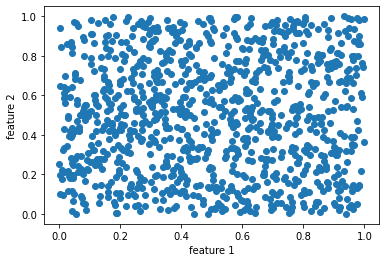

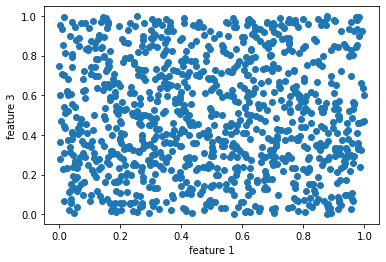

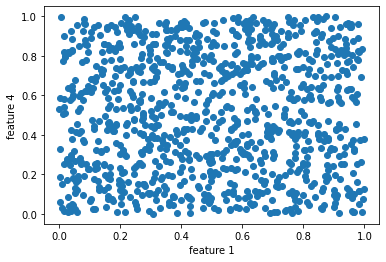

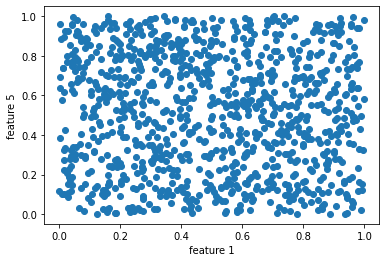

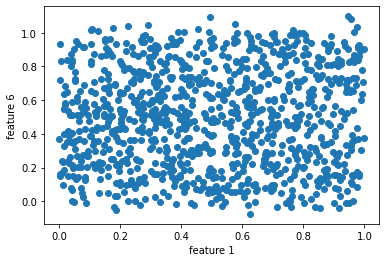

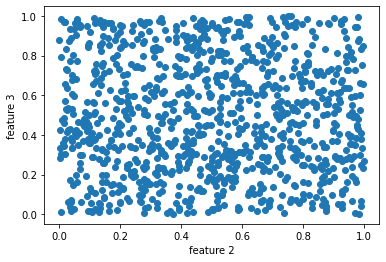

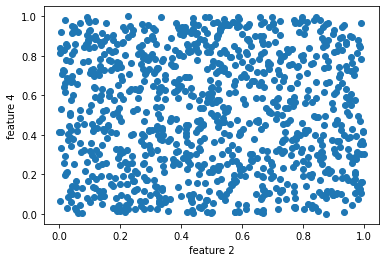

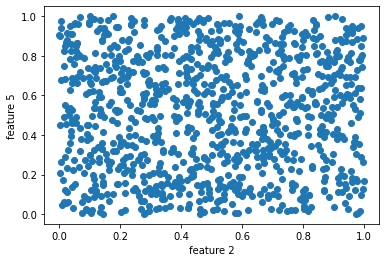

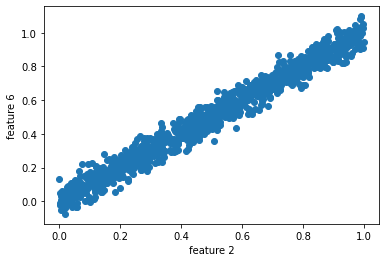

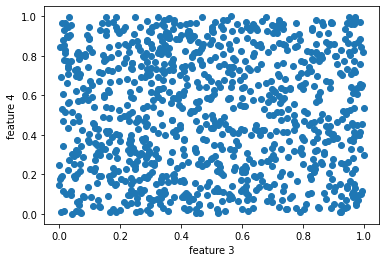

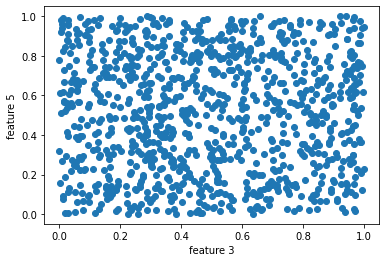

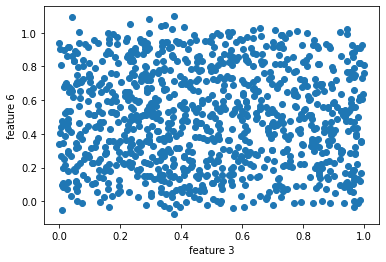

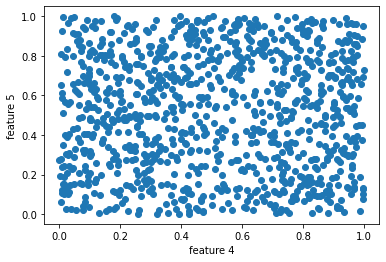

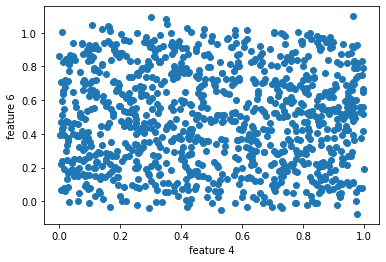

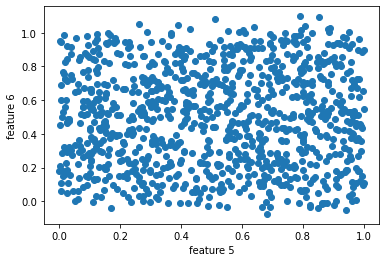

In [4]:
for ind in list(combinations(range(1, X.shape[1]), 2)):
    _, ax = plt.subplots()
    ax.scatter(X[:, ind[0]], X[:, ind[1]])
    ax.set_xlabel('feature ' + str(ind[0]))
    ax.set_ylabel('feature ' + str(ind[1]))

In [5]:
# Show the effect of colinearity on least squares
def test_impact_colinearity(correlated=True):
    print('Actual coefficients = ' + str(COEF))
    res = []
    for i in range(10):
        (X, y) = generate_dataset(correlated=correlated)
        res.append(np.dot(y, np.dot(X, np.linalg.inv(np.dot(X.T, X)))))
        rmse = np.power(np.sum(np.power(y - np.dot(np.array(res[-1]), X.T), 2)), 0.5) / X.shape[0]
        print("coef = " + str(res[-1]) + ", RMSE = " + str(rmse))
    print('Coef. standard deviation: '+ str(np.std(np.array(res), axis = 0)))

In [6]:
test_impact_colinearity(correlated=True)

Actual coefficients = [ 1.   2.  -2.   1.5  3.  -1.   4. ]
coef = [ 0.9965107   1.99927339 -1.99936934  1.50159804  2.98875031 -0.9885362
  3.9996451 ], RMSE = 0.0015898422927580215
coef = [ 0.99950559  1.99843193 -2.01456514  1.50095548  3.00090876 -1.00754601
  4.01959242], RMSE = 0.0015912346424449787
coef = [ 0.99178267  1.99879751 -1.91831353  1.50050349  3.0013661  -0.99461403
  3.93173005], RMSE = 0.001586760334600461
coef = [ 0.99054225  2.00792518 -2.02091503  1.50368697  3.00058987 -0.99486454
  4.0167689 ], RMSE = 0.0015640339876951232
coef = [ 1.0088017   1.99945736 -2.02670844  1.48964203  2.99871506 -1.00006394
  4.02031037], RMSE = 0.0015955417291597393
coef = [ 0.99385189  2.00315949 -1.9943609   1.50084899  2.99774393 -0.99237789
  3.99678485], RMSE = 0.0015697095768933554
coef = [ 0.99942557  2.00674378 -2.00947469  1.49681823  2.99718828 -1.0060693
  4.01346169], RMSE = 0.0015384947467944824
coef = [ 0.99981237  2.00503109 -2.02705446  1.49331634  2.99813895 -0.99782

In [7]:
# Are we sure that this is not noise effect?
# Yes, the variability of the highly correlated dependent variables is an 
# order of magnitude higher than those that are not correlated (see cell above)
# The bias increases, the variance decreases :)
test_impact_colinearity(correlated=False)

Actual coefficients = [ 1.   2.  -2.   1.5  3.  -1.   4. ]
coef = [ 1.00135083  2.00793214 -2.0025548   1.49762268  2.99453308 -1.0060362
  4.00511034], RMSE = 0.0015873859090723681
coef = [ 1.00293272  1.99982825 -1.99266896  1.48665514  2.99615396 -0.99920798
  4.00372648], RMSE = 0.0015850737978183706
coef = [ 0.99784578  2.00186111 -1.98903813  1.4962595   3.00078044 -1.00445465
  3.99666885], RMSE = 0.0015633375155966528
coef = [ 1.00554079  2.0069917  -1.98553367  1.49078303  2.99597014 -1.00980112
  3.9919976 ], RMSE = 0.001637001201562669
coef = [ 1.00664362  2.00533352 -2.00178343  1.49367586  2.9996429  -0.99931394
  3.99343812], RMSE = 0.0015344373032543472
coef = [ 1.01206666  1.98797821 -2.00523999  1.49956928  2.9959121  -0.99668255
  4.00015535], RMSE = 0.0015453622048243636
coef = [ 0.98930646  2.00116355 -1.99608804  1.50345628  3.01515103 -0.99764213
  3.99520177], RMSE = 0.0015412386667864025
coef = [ 0.99492051  2.00689914 -2.00289886  1.49827832  2.99542134 -0.9953

In [8]:
# Ridge regression implementation
def ridge_regression(k, X, y):
    # Standardising the independent variables
    X_s = np.copy(X)
    X_s[:, 1:] = (X_s[:, 1:] - np.mean(X_s[:, 1:], axis=0)) / np.std(X_s[:, 1:])
    
    return np.matmul(np.matmul(np.linalg.inv(np.matmul(X_s.T, X_s) + k * np.identity(X_s.shape[1])), X_s.T), y)

In [9]:
def data_folds(X, k = 10):
    fold_size = int(len(X) / k)
    partitions = list(range(len(X)))
    random.shuffle(partitions)
    return np.array(partitions)[0:k * fold_size].reshape(k, fold_size)

In [10]:
# My initial mistake with the ridge plotwas to use a too small value of K. That's why in some cases the coefficients didn't seem to converge to zero
# Another error is that the independent variables have to be standardised

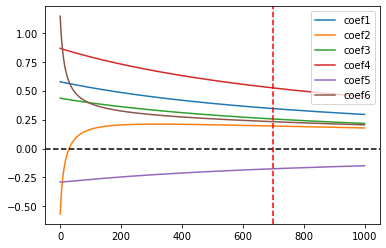

In [11]:
# Selecting k with a ridge trace
columns = []
for i in range(len(COEF)):
    columns.append('coef' + str(i))
trace = pd.DataFrame(index = K, columns = columns)
for k in K:
    trace.loc[k] = ridge_regression(k, X, y)

fig, ax = plt.subplots()
for i in range(1, X.shape[1]):
    ax.plot(trace['coef' + str(i)])
plt.axhline(y=0, color='k', linestyle='--')
ax.legend(trace.columns[1:])
ax.axvline(x = 700, color = 'r', linestyle = '--')

In [12]:
# Selecting k with close validation
folds = data_folds(X)
rmse_train_mean = []
rmse_train_std = []
rmse_test_mean = []
rmse_test_std = []
for k in K:
    rmse_train = []
    rmse_test = []
    for i in range(folds.shape[0]):
        x_test = X[folds[i, :], :]
        y_test = y[folds[i, :]]
        indexes = folds[[j for j in range(folds.shape[0]) if j!=i], :].flatten()
        x_train = X[indexes, :]
        y_train = y[indexes]
        
        coef = ridge_regression(k, x_train, y_train)
        x_train_s = np.copy(x_train)
        x_train_s[:, 1:] = (x_train_s[:, 1:] - np.mean(x_train_s[:, 1:], axis=0)) / np.std(x_train_s[:, 1:])
        x_test_s = np.copy(x_test)
        x_test_s[:, 1:] = (x_test_s[:, 1:] - np.mean(x_test_s[:, 1:], axis=0)) / np.std(x_test_s[:, 1:])
        
        rmse_train.append(np.power(np.sum(np.power(y_train - np.dot(np.array(coef), x_train_s.T), 2)), 0.5) / x_train_s.shape[0])
        rmse_test.append(np.power(np.sum(np.power(y_test - np.dot(np.array(coef), x_test_s.T), 2)), 0.5) / x_test_s.shape[0])
    rmse_train_mean.append(np.mean(rmse_train))
    rmse_train_std.append(np.std(rmse_train))
    rmse_test_mean.append(np.mean(rmse_test))
    rmse_test_std.append(np.std(rmse_test))
    
rmse_train_mean = np.array(rmse_train_mean)
rmse_train_std = np.array(rmse_train_std)
rmse_test_mean = np.array(rmse_test_mean)
rmse_test_std = np.array(rmse_test_std)

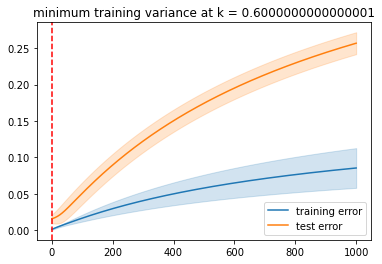

In [13]:
# Using the value of K that minimises variability for the training data
# Multiplying training variance times 100 to make it more visible
fig, ax = plt.subplots()
ax.plot(K, rmse_train_mean, color = 'C0')
ax.plot(K, rmse_test_mean, color = 'C1')
ax.fill_between(K, rmse_train_mean - rmse_train_std * 100, rmse_train_mean + rmse_train_std * 100, color = 'C0', alpha = 0.2)
ax.fill_between(K, rmse_test_mean - rmse_test_std, rmse_test_mean + rmse_test_std, color = 'C1', alpha = 0.2)
min_error = K[np.argmin(rmse_test_mean)]
ax.axvline(x = min_error, color = 'r', linestyle = '--')
ax.set_title('minimum training variance at k = ' + str(min_error))
ax.legend(['training error', 'test error'])

In [14]:
# TODO: refactor rmse outside of the functiosn. The same to the one to standardise the data